In [17]:
import itertools
import os
import re
import unicodedata
import torch
from torch import nn
from torch.optim import Adam
from model import load_models, Encoder, AttentionDecoder, EMBEDDING_SIZE
import random
from prepared import load_voc, batch2train_data, input_var, indexesFromSentence
import matplotlib.pyplot as plt
import string

In [2]:
data, Vocabulary = load_voc()

In [3]:
device = "cuda:0"
batch_size = 2

In [4]:
Vocabulary.num_words

35691

In [5]:
# embedding = nn.Embedding(2**16, EMBEDDING_SIZE).to(device)
# encoder = Encoder(embedding).to(device)
# decoder = AttentionDecoder(embedding).to(device)

In [6]:
encoder, decoder, embedding = load_models()

encoder_optim = Adam(encoder.parameters(), lr=5e-3)
decoder_optim = Adam(decoder.parameters(), lr=1e-3)

encoder.epochs

325000

In [7]:
def calculate_loss(inp, target, mask):

    loss = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = loss.masked_select(mask).mean()
    loss = loss.to(device)

    return loss

In [8]:
def train(epochs):
    # для вывода графика
    history = []
    short_mem = []
    print(1)
    for _ in range(epochs):
        # всё стандартно
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        inp, lenghts, target, mask, max_target_len = batch2train_data([random.choice(data) \
                                                                       for _ in range(batch_size)])

        inp = inp.to(device)
        lenghts = lenghts.to(device)
        target = target.to(device)
        mask = mask.to(device)
        # провожу через енкодинг
        encoder_out, encoder_hidden = encoder(inp, lenghts)
        # начальное значение для работы декодера
        decoder_input = torch.ones(batch_size).long().to(device).unsqueeze(0)

        loss = 0

        decoder_hidden = encoder_hidden[:2]
        for i in range(max_target_len):
            decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_out)

            decoder_input = torch.LongTensor([[decoder_out.topk(1)[1][x][0] for\
                                               x in range(batch_size)]]).to(device)

            loss += calculate_loss(decoder_out, target[i], mask[i])

        short_mem.append(loss)

        if not encoder.epochs % 10000:
            print(f'{encoder.epochs}  {torch.tensor(short_mem).mean()}')
            history.append(torch.tensor(short_mem).mean())
            short_mem = []

        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        encoder.epochs += 1

        # save model

        if not encoder.epochs % 25000:

            torch.save(encoder, f"models/encoder{encoder.epochs}")
            torch.save(decoder, f"models/decoder{encoder.epochs}")
            torch.save(embedding, f"models/embedding{encoder.epochs}")

    return history

In [9]:
%%time
history = train(int(5e4))

1
280000  222.98318481445312
290000  209.33255004882812
300000  197.84295654296875
310000  190.88201904296875
320000  188.64288330078125
CPU times: user 2h 9min 39s, sys: 53.2 s, total: 2h 10min 32s
Wall time: 2h 10min 40s


In [10]:
encoder.epochs

325000

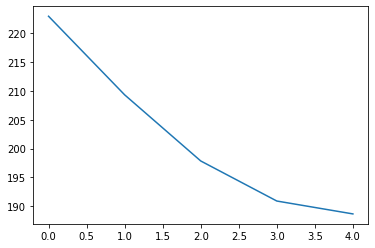

In [11]:
plt.plot(history)

In [19]:
# embedding = nn.Embedding(2**16, EMBEDDING_SIZE).to(device)
# encoder = Encoder(embedding).to(device)
# decoder = AttentionDecoder(embedding).to(device)

In [50]:
def greedy_search(sequence, length, maximum=30):
    # всё также как на тренировке
    encoder_out, encoder_hidden = encoder(sequence, length)

    decoder_hidden = encoder_hidden[:2]
    decoder_input = torch.ones(1, 1, device=device, dtype=torch.long)
    # здесь складываються ответы по жадному методу
    all_tokens = torch.zeros([0], device=device, dtype=torch.long)
    # всего будет 30 оборотов, при выводе отрежуться ненужные токены, а 30, чтобы больше не было
    for _ in range(maximum):

        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_out)

        _, decoder_input = torch.max(decoder_output, dim=1)

        all_tokens = torch.cat((all_tokens, decoder_input), dim=0)

        decoder_input = decoder_input.unsqueeze(0)

    return all_tokens

In [51]:
clean = lambda text: "".join(x for x in text.lower() if x not in string.punctuation)

In [58]:
text = "а"
text = clean(text)
text = torch.tensor([indexesFromSentence(text)])

In [59]:
length = torch.tensor([len(text[0])])
length

tensor([2])

In [60]:
text = text.transpose(0, 1).long().to(device)
text

tensor([[80],
        [ 2]], device='cuda:0')

In [61]:
text = greedy_search(text, length)

In [62]:
text

tensor([80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4], device='cuda:0')

In [63]:
for token in text:
    try:
        print(Vocabulary.index2word[token.item()])
    except:
        print(token)



а





























